<a href="https://colab.research.google.com/github/javadvahid/deepLearning/blob/main/FasterRCNNPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d sixhky/open-images-bus-trucks/
    !unzip -qq open-images-bus-trucks.zip
    !rm open-images-bus-trucks.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.6 MB/s eta 0:00

Saving kaggle.json to kaggle.json
kaggle.json
100% 366M/367M [00:20<00:00, 22.3MB/s]
100% 367M/367M [00:20<00:00, 18.8MB/s]


In [ ]:
#from torch_snippets import *
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

imageRoot = 'images/images'
dfRaw = df = pd.read_csv('df.csv')

In [ ]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
label2target = {l: t+1 for t, l in enumerate(dfRaw['LabelName'].unique())}
label2target['background'] = 0
target2label = {t: l for l, t in label2target.items()}
backgroundClass = label2target['background']
numClasses = len(target2label)


In [ ]:
def preProcessImage(img):
  img = torch.tensor(img).permute(2, 0, 1)
  return img.to(device).float()

In [ ]:
class openDataset(Dataset):
  w, h = 224, 224
  def __init__(self, df, imageDir=imageRoot):
    self.imageDir = imageDir
    self.files = glob.glob(self.imageDir + '/*')
    self.df = df
    self.imageInfos = df.ImageID.unique()
  def __getitem__(self, idx):
    imgId = self.imageInfos[idx]
    imgPath = f"{self.imageDir}/{imgId}.jpg"
    img = Image.open(imgPath).convert("RGB")
    #plt.imshow(img)
    img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
    data = df[df['ImageID'] == imgId]
    labels = data['LabelName'].values.tolist()
    data = data[['XMin', 'YMin', 'XMax', 'YMax']].values
    data[:, [0, 2]] *= self.w
    data[:, [1, 3]] *= self.h
    boxes = data.astype(np.uint32).tolist()
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
    img = preProcessImage(img)
    return img, target
  def collate_fn(self, batch):
    return tuple(zip(*batch))
  def __len__(self):
    return len(self.imageInfos)

In [ ]:
from sklearn.model_selection import train_test_split
trainIds, valIds = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trainDf, valDf = df[df['ImageID'].isin(trainIds)], df[df['ImageID'].isin(valIds)]
len(trainDf), len(valDf)

trainDs = openDataset(trainDf)
testDs = openDataset(valDf)

trainLoader = DataLoader(trainDs, batch_size=4, collate_fn=trainDs.collate_fn, drop_last=True)
testLoader = DataLoader(testDs, batch_size=4, collate_fn=testDs.collate_fn, drop_last=True)

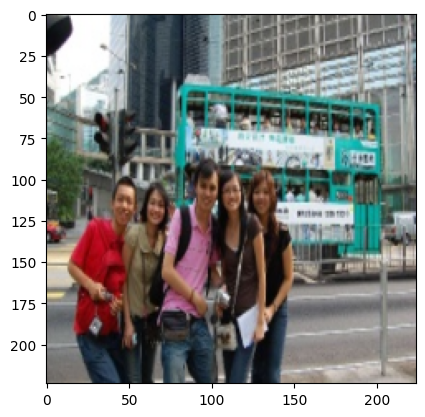

In [ ]:
img = Image.open('/content/images/images/0000599864fd15b3.jpg').convert("RGB")
#
img = np.array(img.resize((224, 224), resample=Image.BILINEAR))/255.
plt.imshow(img)

<function matplotlib.pyplot.show(close=None, block=None)>

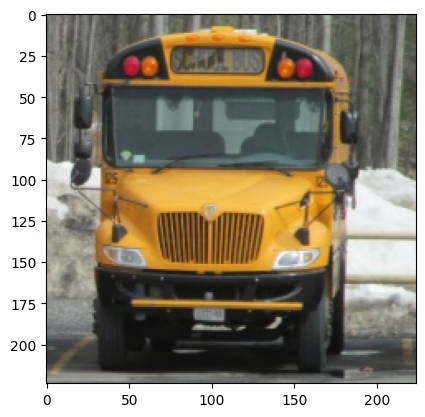

In [ ]:
test, ttest = trainDs[12]
plt.imshow(test.cpu().permute(1, 2, 0))
plt.show

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def getModel():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  inFeatures = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(inFeatures, numClasses)
  return model

In [ ]:
def trainBatch(inputs, model, optimizer):
  model.train()
  input, targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input, targets)
  loss = sum(loss for loss in losses.values())
  loss.backward()
  optimizer.step()
  return loss, losses

@torch.no_grad()
def validateBatch(inputs, model):
  model.train()
  input, targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input, targets)
  loss = sum(loss for loss in losses.values())
  return loss, losses

In [ ]:
model = getModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
nEpochs = 5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.9MB/s]


In [ ]:
for epoch in range(nEpochs):
  _n = len(trainLoader)
  for ix, inputs in enumerate(trainLoader):
    loss, losses = trainBatch(inputs, model, optimizer)
    locLoss, regLoss, objectnessLoss, rpnBoxRegLoss =\
      [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
    pos = (epoch + (ix+1)/_n)
    if ix % 500 == 0:
      print(f"{pos}>> trnLoss:{loss.item()}, trnLocLoss:{locLoss.item()}, trnRegLoss:{regLoss.item()}, trnObjectnessLoss:{objectnessLoss.item()}, trnRpnBoxRegLoss:{rpnBoxRegLoss.item()}")

  _n = len(testLoader)
  for ix, inputs in enumerate(testLoader):
    loss, losses = validateBatch(inputs, model)
    locLoss, regLoss, objectnessLoss, rpnBoxRegLoss =\
      [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
    pos = (epoch + (ix+1)/_n)
    if ix % 100 == 0:
      print(f"{pos}>> valLoss:{loss.item()}, valLocLoss:{locLoss.item()}, valRegLoss:{regLoss.item()}, valObjectnessLoss:{objectnessLoss.item()}, valRpnBoxRegLoss:{rpnBoxRegLoss.item()}")


In [ ]:
print(_n)

3425


In [ ]:
from torchvision.ops import nms
def decodeOutput(output):
  bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
  labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
  confs = output['scores'].cpu().detach().numpy()
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
  if len(ixs) == 1:
    bbs, confs, labels = [np. array([tensor]) for tensor in [bbs, confs, labels]]
  return bbs.tolist(), confs.tolist(), labels.tolist()

In [ ]:
import cv2
from matplotlib import pyplot as plt

def showImgWithBbox(im, bbs, labels):
  imcopy = np.copy(np.array(im))
  print(imcopy.shape)
  #imcopy = np.transpose(imcopy, (1, 2, 0))

  print(imcopy.shape)
  imcopy = cv2.cvtColor(imcopy, cv2.COLOR_RGBA2BGR)
  #uint8_image = numpy_image.astype(np.uint8)
  for i, bb in enumerate(bbs):
    print(i, bb)
    cv2.rectangle(imcopy, bb[0:2], bb[2:4], (255, 205, 51), 2)
    cv2.putText(imcopy, '%s' % (labels[i]), (bb[0], bb[1] - 5),
              cv2.FONT_HERSHEY_PLAIN,
              1.0, (0, 0, 255), thickness=1)
  return imcopy

(224, 224, 3)
(224, 224, 3)
0 [67, 108, 91, 139]
1 [171, 128, 213, 143]
2 [57, 111, 68, 136]
0
(224, 224, 3)
(224, 224, 3)
0 [170, 175, 222, 205]
1 [162, 135, 205, 179]
2 [76, 102, 84, 110]
3 [73, 188, 93, 219]
4 [61, 103, 73, 112]
5 [12, 102, 28, 120]
6 [175, 110, 190, 122]
7 [98, 164, 111, 201]
8 [143, 107, 170, 132]
9 [36, 105, 51, 120]
10 [217, 113, 222, 121]
11 [193, 110, 203, 118]
12 [92, 103, 98, 107]
13 [28, 107, 36, 113]
1
(224, 224, 3)
(224, 224, 3)
0 [2, 78, 71, 153]
1 [116, 38, 220, 103]
2
(224, 224, 3)
(224, 224, 3)
0 [0, 121, 36, 158]
1 [43, 39, 170, 195]
2 [31, 110, 51, 124]
3


(224, 224, 3)
(224, 224, 3)
0 [71, 70, 155, 190]
1 [0, 127, 27, 191]
0
(224, 224, 3)
(224, 224, 3)
0 [1, 9, 189, 117]
1 [211, 9, 223, 98]
1
(224, 224, 3)
(224, 224, 3)
0 [0, 5, 216, 224]
1 [197, 78, 219, 166]
2
(224, 224, 3)
(224, 224, 3)
0 [66, 87, 201, 207]
1 [0, 129, 21, 176]
2 [210, 22, 222, 144]
3


(224, 224, 3)
(224, 224, 3)
0 [17, 17, 223, 224]
0
(224, 224, 3)
(224, 224, 3)
0 [0, 74, 31, 145]
1 [55, 52, 183, 121]
2 [177, 77, 222, 190]
3 [159, 91, 176, 114]
4 [104, 101, 126, 130]
1
(224, 224, 3)
(224, 224, 3)
0 [2, 3, 106, 214]
1 [174, 68, 222, 143]
2 [105, 114, 114, 137]
3 [113, 110, 180, 145]
4 [151, 101, 168, 117]
2
(224, 224, 3)
(224, 224, 3)
0 [60, 91, 152, 177]
1 [33, 110, 57, 134]
2 [0, 106, 20, 145]
3 [0, 85, 16, 108]
4 [152, 114, 163, 143]
5 [217, 129, 222, 143]
3


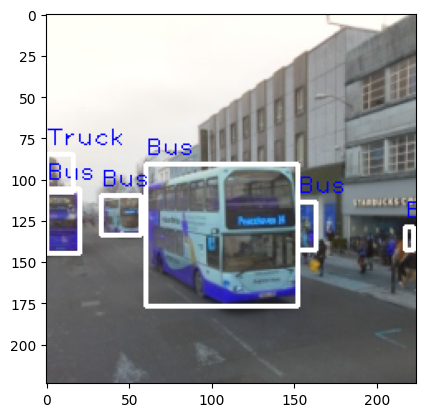

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(testLoader):
  if ix == 3: break
  images = [im for im in images]
  outputs = model(images)
  for ix, output in enumerate(outputs):
    bbs, confs, labels = decodeOutput(output)
    #plt.imshow(images[ix].view(1, 2, 0))
    result = showImgWithBbox(images[ix].cpu().permute(1, 2, 0), bbs, labels)
    print(ix)
    plt.imshow(result)
    plt.show

